In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DXG Historical Data.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
18/18 [==============================] - 5s 134ms/step - loss: 0.0233 - val_loss: 0.0051
Epoch 2/100
18/18 [==============================] - 1s 72ms/step - loss: 0.0045 - val_loss: 4.1990e-04
Epoch 3/100
18/18 [==============================] - 1s 48ms/step - loss: 0.0012 - val_loss: 4.6100e-04
Epoch 4/100
18/18 [==============================] - 1s 49ms/step - loss: 6.9519e-04 - val_loss: 3.8737e-04
Epoch 5/100
18/18 [==============================] - 1s 48ms/step - loss: 6.1551e-04 - val_loss: 3.3479e-04
Epoch 6/100
18/18 [==============================] - 1s 48ms/step - loss: 5.9302e-04 - val_loss: 3.1781e-04
Epoch 7/100
18/18 [==============================] - 1s 48ms/step - loss: 5.7377e-04 - val_loss: 3.2769e-04
Epoch 8/100
18/18 [==============================] - 1s 48ms/step - loss: 5.9833e-04 - val_loss: 3.1244e-04
Epoch 9/100
18/18 [==============================] - 1s 47ms/step - loss: 5.5455e-04 - val_loss: 3.0114e-04
Epoch 10/100
18/18 [=======================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

7/7 [==============================] - 0s 16ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 18261.256886864827


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.9983896669282
Testing MAE: 18136.18301911169


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.3245159387588501], [0.3239293098449707], [0.32246702909469604], [0.32075589895248413], [0.31891223788261414], [0.3169609308242798], [0.31491830945014954], [0.3127983510494232], [0.31061267852783203], [0.308370977640152], [0.3060815930366516], [0.3037516176700592], [0.3013874590396881], [0.2989947497844696], [0.29657861590385437], [0.2941436171531677], [0.2916939854621887], [0.289233535528183], [0.28676581382751465], [0.28429391980171204], [0.28182080388069153], [0.279349148273468], [0.27688127756118774], [0.2744193971157074], [0.27196553349494934], [0.2695213556289673], [0.2670886218547821], [0.26466870307922363], [0.26226288080215454], [0.25987234711647034], [0.25749799609184265], [0.2551408112049103], [0.25280144810676575], [0.2504807710647583], [0.24817915260791779], [0.24589715898036957], [0.24363520741462708], [0.2413935363292694], [0.23917245864868164], [0.23697218298912048], [0.2347928285598755], [0.23263445496559143], [0.23049713671207428], [0.22838087379932404], [0.2262856

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[19723.27477409],
       [19699.80322328],
       [19641.2960544 ],
       [19572.8321974 ],
       [19499.0656587 ],
       [19420.99210712],
       [19339.26498758],
       [19254.443544  ],
       [19166.99281931],
       [19077.30034926],
       [18985.70001083],
       [18892.47559943],
       [18797.88348489],
       [18702.14903415],
       [18605.47734307],
       [18508.05085155],
       [18410.03888293],
       [18311.59406666],
       [18212.85830047],
       [18113.95559579],
       [18015.00400199],
       [17916.11083665],
       [17817.36910837],
       [17718.86705606],
       [17620.68576411],
       [17522.89200794],
       [17425.55614017],
       [17328.73301203],
       [17232.47389749],
       [17136.82649324],
       [17041.82657183],
       [16947.51348304],
       [16853.91346005],
       [16761.06108299],
       [16668.97125708],
       [16577.66663825],
       [16487.16392035],
       [16397.47264272],
       [16308.60532575],
       [16220.57031636],


In [18]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[-101:])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [19]:
print(y_pred_with_test_data.shape)
test_data.shape

(311,)


(311, 1)

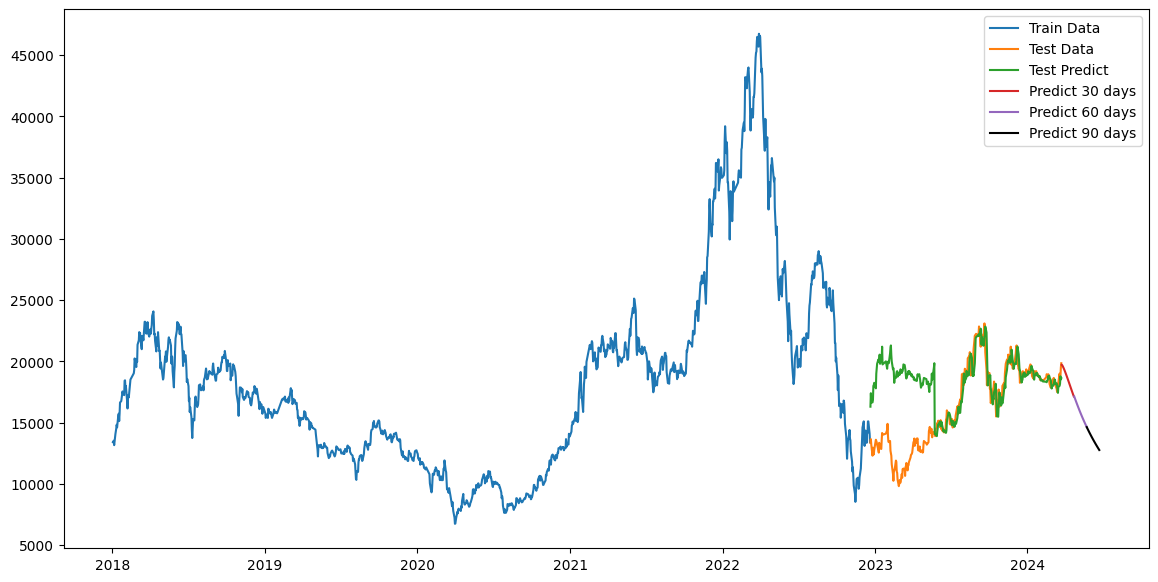

In [21]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()